<a href="https://colab.research.google.com/github/vfrantc/predanalytics/blob/main/final_submission_frants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt install libgraphviz-dev
!pip install -q pygraphviz
!pip install -q pomegranate

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
import os
import datetime
from collections import defaultdict

import numpy as np
import pandas as pd

from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers

import pomegranate as pm

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def anova(pred_er, true_er):
  F, p = stats.f_oneway(pred_er, true_er)
  return p

def ttest(pred_er, true_er):
  Ts, p = stats.ttest_ind(pred_er, true_er)
  return p

# Load datasheet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir data
!cp '/content/drive/My Drive/pred-analit/GC-Predictive-Analytics-worksheet - Sheet1 - week6.csv' data
df = pd.read_csv('data/GC-Predictive-Analytics-worksheet - Sheet1 - week6.csv')
df = df.drop([11, 12])
df = df.reset_index()
del df['cluster']
del df['Unnamed: 12']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘data’: File exists


In [ ]:
df

,index,Gender,Age,Ethnicity,Income,Work hours,Health condition,Education,Motivation,Attitude,Intention,Ownership,1,ER,2,ER.1,3,ER.2,4,ER.3,5,ER.4,6,ER.5,7,ER.6,8,ER.7,9,ER.8,10,ER.9,11,ER.10,12,ER.11,13,ER.12,14,ER.13,15,ER.14,16 Recommendation,Actual ER,17 Recommendation,Actual ER.1,18 Recommendation,Estimated ER
0,0,Female,44,Caucasian,"150,000-199,999",50+ hrs/week,Good,4-year college degree,0.265623,0.526590,0.507169,0.559363,Phy,0.166667,diet,0.714286,diet,0.428571,diet,0.571429,diet,0.750000,diet,0.428571,diet,0.857143,diet,1.0,diet,1.0,diet,0.285714,diet,0.571429,diet,0.500000,Phy,0.0,Phy,0.000000,Phy,0.000000,Phy,0,diet,0.0,NaN,NaN
1,1,Female,37,Asian,"100,000-149,999",16-35 hrs/week,Excellent,2-year college degree,0.386128,0.896973,0.736022,0.924759,diet,0.000000,diet,0.428571,diet,1.000000,diet,0.857143,diet,0.875000,diet,0.857143,diet,1.000000,diet,1.0,diet,1.0,diet,0.857143,diet,0.857143,diet,1.000000,diet,1.0,diet,0.857143,diet,0.428571,Phy,0,diet,0.0,NaN,NaN
2,2,Female,63,Caucasian,"0-24,999",50+ hrs/week,Excellent,2-year college degree,0.147511,0.593162,0.574159,0.928628,diet,0.000000,Phy,0.142857,Phy,0.000000,Phy,0.571429,Phy,0.000000,Phy,0.000000,Phy,0.000000,Phy,0.0,Phy,0.0,Phy,0.000000,Phy,0.000000,Phy,0.000000,diet,1.0,phy,1.000000,diet,0.333333,diet,0.5714285714,NaN,NaN,NaN,NaN
3,3,Female,37,African American,"0-24,999",1-15 hrs/week,Fair,"Some college, but no degree",0.492041,0.586625,0.645084,0.799052,Phy,0.000000,diet,0.000000,phy,0.000000,diet,0.000000,diet,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Female,62,African American,"50,000-99,999",1-15 hrs/week,Good,4-year college degree,0.594119,0.563496,0.659809,0.820454,diet,0.285714,diet,1.000000,Phy,0.470588,diet,0.900000,phy,0.916667,diet,1.000000,diet,0.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,Male,59,Caucasian,"50,000-99,999",36-50 hrs/week,Fair,4-year college degree,0.760602,0.541951,0.750184,0.664756,phy,0.058824,diet,0.500000,diet,0.500000,phy,0.750000,diet,0.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,Female,28,Asian,"50,000-99,999",50+ hrs/week,Good,4-year college degree,0.653543,0.731372,0.751441,0.976597,phy,0.250000,diet,0.000000,diet,0.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,Male,60,Asian,"150,000-199,999",50+ hrs/week,Good,Some graduate work,0.736708,0.675436,0.760342,0.974514,phy,0.166667,diet,0.000000,diet,0.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,Male,57,African American,"25,000-49,000",50+ hrs/week,Excellent,Some graduate work,0.550593,0.765072,0.800639,0.804968,diet,0.833333,Phy,0.857143,Phy,0.857143,Phy,1.000000,Phy,1.000000,Phy,0.714286,Phy,1.000000,Phy,1.0,Phy,1.0,Phy,1.000000,Phy,1.000000,Phy,0.833333,Phy,1.0,Phy,1.000000,Phy,1.000000,NaN,DROPPED,NaN,NaN,NaN,NaN
9,9,Female,47,Caucasian,"0-24,999",36-50 hrs/week,Very Good,4-year college degree,0.131661,0.422950,0.417563,0.742601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Rearange data

In [ ]:
cat_fields = ['Gender', 'Ethnicity', 'Income', 'Work hours', 'Health condition', 'Education']
df[cat_fields] = df[cat_fields].apply(lambda col:pd.Categorical(col).codes).replace(-1,np.nan)

df['Age'] = df['Age'].replace("40-50's", '45')
df['Age'] = df['Age'].astype('int32')
df['Age'] = pd.qcut(df['Age'], 4, labels=False )

cont_fields = ['Motivation', 'Attitude', 'Intention', 'Ownership']
pca = PCA().fit(df[cont_fields].fillna(0).to_numpy())
data = pca.transform(df[cont_fields].fillna(0).to_numpy())
df['Factor 1'] = pd.qcut(data[:, 0], 5, labels=False)
df['Factor 2'] = pd.qcut(data[:, 1], 5, labels=False)

del df['Motivation']
del df['Attitude']
del df['Intention']
del df['Ownership']

In [ ]:
df

,index,Gender,Age,Ethnicity,Income,Work hours,Health condition,Education,1,ER,2,ER.1,3,ER.2,4,ER.3,5,ER.4,6,ER.5,7,ER.6,8,ER.7,9,ER.8,10,ER.9,11,ER.10,12,ER.11,13,ER.12,14,ER.13,15,ER.14,16 Recommendation,Actual ER,17 Recommendation,Actual ER.1,18 Recommendation,Estimated ER,Factor 1,Factor 2
0,0,0,1,2,2.0,3.0,2.0,1.0,Phy,0.166667,diet,0.714286,diet,0.428571,diet,0.571429,diet,0.750000,diet,0.428571,diet,0.857143,diet,1.0,diet,1.0,diet,0.285714,diet,0.571429,diet,0.500000,Phy,0.0,Phy,0.000000,Phy,0.000000,Phy,0,diet,0.0,NaN,NaN,3,3
1,1,0,0,1,1.0,1.0,0.0,0.0,diet,0.000000,diet,0.428571,diet,1.000000,diet,0.857143,diet,0.875000,diet,0.857143,diet,1.000000,diet,1.0,diet,1.0,diet,0.857143,diet,0.857143,diet,1.000000,diet,1.0,diet,0.857143,diet,0.428571,Phy,0,diet,0.0,NaN,NaN,0,3
2,2,0,3,2,0.0,3.0,0.0,0.0,diet,0.000000,Phy,0.142857,Phy,0.000000,Phy,0.571429,Phy,0.000000,Phy,0.000000,Phy,0.000000,Phy,0.0,Phy,0.0,Phy,0.000000,Phy,0.000000,Phy,0.000000,diet,1.0,phy,1.000000,diet,0.333333,diet,0.5714285714,NaN,NaN,NaN,NaN,3,4
3,3,0,0,0,0.0,0.0,1.0,2.0,Phy,0.000000,diet,0.000000,phy,0.000000,diet,0.000000,diet,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2
4,4,0,3,0,4.0,0.0,2.0,1.0,diet,0.285714,diet,1.000000,Phy,0.470588,diet,0.900000,phy,0.916667,diet,1.000000,diet,0.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1
5,5,1,2,2,4.0,2.0,1.0,1.0,phy,0.058824,diet,0.500000,diet,0.500000,phy,0.750000,diet,0.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0
6,6,0,0,1,4.0,3.0,2.0,1.0,phy,0.250000,diet,0.000000,diet,0.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
7,7,1,2,1,2.0,3.0,2.0,3.0,phy,0.166667,diet,0.000000,diet,0.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
8,8,1,2,0,3.0,3.0,0.0,3.0,diet,0.833333,Phy,0.857143,Phy,0.857143,Phy,1.000000,Phy,1.000000,Phy,0.714286,Phy,1.000000,Phy,1.0,Phy,1.0,Phy,1.000000,Phy,1.000000,Phy,0.833333,Phy,1.0,Phy,1.000000,Phy,1.000000,NaN,DROPPED,NaN,NaN,NaN,NaN,1,3
9,9,0,1,2,0.0,2.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4


In [ ]:
td = dict()
td['Gender'] = [0, 0, 0, 0, 0, 1, 0, 1]
td['Age'] = [1, 0, 3, 0, 3, 2, 0, 2]
td['Ethnicity'] = [2, 1, 2, 0, 0, 2, 1, 1]
td['Income'] = [2.0, 1.0, 0.0, 0.0, 4.0, 4.0, 4.0, 2.0]
td['Work hours'] = [3.0, 1.0, 3.0, 0.0, 0.0, 2.0, 3.0, 3.0]
td['Health condition'] = [2.0, 0.0, 0.0, 1.0, 2.0, 1.0, 2.0, 2.0]
td['Education'] = [1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 1.0, 3.0]
td['Factor 1'] = [3, 0, 3, 3, 2, 1, 0, 0]
td['Factor 2'] = [3, 3, 4, 2, 1, 0, 1, 0]
td['Previous er'] = [0, 0, 0.33333, 0.0, 1.0, 0.75, 0.0, 0.0]
td['Rec'] = [1, 1, 1, 1, 1, 1, 1, 1]
td['Er'] = [0,0, 0.57142, 0.0, 0.90, 0.3, 0.1, 0.3]
test_data = pd.DataFrame(data=td)

In [ ]:
test_data

,Gender,Age,Ethnicity,Income,Work hours,Health condition,Education,Factor 1,Factor 2,Previous er,Rec,Er
0,0,1,2,2.0,3.0,2.0,1.0,3,3,0.00000,1,0.00000
1,0,0,1,1.0,1.0,0.0,0.0,0,3,0.00000,1,0.00000
2,0,3,2,0.0,3.0,0.0,0.0,3,4,0.33333,1,0.57142
3,0,0,0,0.0,0.0,1.0,2.0,3,2,0.00000,1,0.00000
4,0,3,0,4.0,0.0,2.0,1.0,2,1,1.00000,1,0.90000
5,1,2,2,4.0,2.0,1.0,1.0,1,0,0.75000,1,0.30000
6,0,0,1,4.0,3.0,2.0,1.0,0,1,0.00000,1,0.10000
7,1,2,1,2.0,3.0,2.0,3.0,0,0,0.00000,1,0.30000


In [ ]:
rec_idxs = [str(i) for i in range(1, 15)]
er_idxs = ['ER']
er_idxs.extend(['ER.{}'.format(i) for i in range(1, 14)])
rec_idxs.append('16 Recommendation ')
rec_idxs.append('17 Recommendation')
er_idxs.append('Actual ER')
er_idxs.append('Actual ER.1')

In [ ]:
data = defaultdict(list)
fields = ['Gender', 'Age', 'Ethnicity', 'Income', 'Work hours', 'Health condition', 'Education', 'Factor 1', 'Factor 2']

for i in range(len(df)):
  for j in range(1, len(rec_idxs)):
      if df[er_idxs[j-1]][i] == 'DROPPED' or df[er_idxs[j]][i] == 'DROPPED':
        continue
      prev_er = float(df[er_idxs[j-1]][i])
      cur_rec = df[rec_idxs[j]][i]
      cur_er = float(df[er_idxs[j]][i])
      if pd.isna(cur_rec):
        if i < 8:
          for field in fields:
            del data[field][-1]
          del data['Previous er'][-1]
          del data['Rec'][-1]
          del data['Er'][-1]
        continue

      if cur_rec == 'Phy':
        cur_rec = 0
      else:
        cur_rec = 1

      for field in fields:
        data[field].append(df[field][i])

      data['Previous er'].append(prev_er)
      data['Rec'].append(cur_rec)
      data['Er'].append(prev_er)
df = pd.DataFrame(data=data)

In [ ]:
df

,Gender,Age,Ethnicity,Income,Work hours,Health condition,Education,Factor 1,Factor 2,Previous er,Rec,Er
0,0,1,2,2.0,3.0,2.0,1.0,3,3,0.166667,1,0.166667
1,0,1,2,2.0,3.0,2.0,1.0,3,3,0.714286,1,0.714286
2,0,1,2,2.0,3.0,2.0,1.0,3,3,0.428571,1,0.428571
3,0,1,2,2.0,3.0,2.0,1.0,3,3,0.571429,1,0.571429
4,1,2,0,3.0,3.0,0.0,3.0,1,3,0.833333,0,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...
77,1,3,2,3.0,2.0,2.0,0.0,1,4,0.000000,1,0.000000
78,1,3,2,3.0,2.0,2.0,0.0,1,4,0.000000,1,0.000000
79,1,3,2,3.0,2.0,2.0,0.0,1,4,0.000000,1,0.000000
80,1,3,2,3.0,2.0,2.0,0.0,1,4,0.000000,1,0.000000


# Try to extract bayesian network structure from data

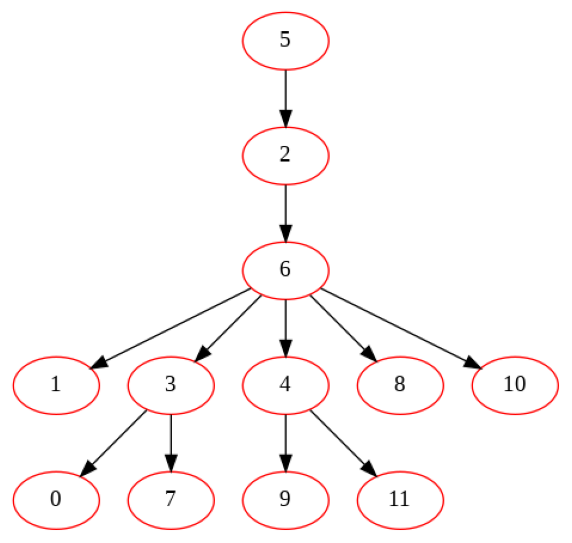

In [ ]:
plt.figure(figsize=(10, 10))
model = pm.BayesianNetwork.from_samples(df, algorithm='exact-dp')
model.plot()

# Regression methods

In [ ]:
df = df.dropna()

In [ ]:
y = df.pop('Er')
X = df

# regular features

In [ ]:
models = []
models.append(('Linear', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('Elastic', ElasticNet()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('DecisionTree', DecisionTreeRegressor()))

# evaluate each model in turn
for name, model in models:
    cv_results = cross_val_score(model, X, y, cv=KFold(n_splits=5, shuffle=True), scoring='r2')
    print("{}: {:.3f} {:.3f}".format(name, cv_results.mean(), cv_results.std()))

Linear: 1.000 0.000
Ridge: 0.955 0.040
Lasso: -0.115 0.134
Elastic: -0.075 0.053
RandomForest: 0.990 0.012
DecisionTree: 0.989 0.008


In [ ]:
test_y = test_data.pop('Er')
test_x = test_data 

In [ ]:
models = []
models.append(('Linear', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('Elastic', ElasticNet()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('DecisionTree', DecisionTreeRegressor()))

for name, model in models:
  model.fit(X, y)
  pred = model.predict(test_x)
  print('{} Anova: {} ttest: {}'.format(name, anova(pred, y), ttest(pred, y)))

Linear Anova: 0.9781991635918711 ttest: 0.9781991635917815
Ridge Anova: 0.682127136982869 ttest: 0.682127136982868
Lasso Anova: 1.0 ttest: 1.0
Elastic Anova: 1.0 ttest: 1.0
RandomForest Anova: 0.9823529532201463 ttest: 0.9823529532200699
DecisionTree Anova: 0.9233844238138856 ttest: 0.9233844238139027


# Multi-layer perceptron

In [ ]:
mlp = tf.keras.models.Sequential()
mlp.add(layers.Dense(12, activation='relu', input_shape=(11, )))
mlp.add(layers.Dropout(0.25))
mlp.add(layers.Dense(12, activation='relu'))
mlp.add(layers.Dense(1, activation='sigmoid'))
mlp.compile(optimizer='adam', loss='mse', metrics=['mse'])
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                144       
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 313
Trainable params: 313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_ = y.to_numpy().reshape(-1, 1).astype('float32')
X_ = X.to_numpy().astype('float32')
print(y.shape)
print(X_.shape)

(56,)
(56, 11)


In [ ]:
mlp.fit(X_, y_, batch_size=4, epochs=100, validation_split=0.25)

Epoch 1/100
11/11 [==============================] - 0s 12ms/step - loss: 0.2375 - mse: 0.2375 - val_loss: 0.3067 - val_mse: 0.3067
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2267 - mse: 0.2267 - val_loss: 0.3092 - val_mse: 0.3092
Epoch 3/100
11/11 [==============================] - 0s 2ms/step - loss: 0.2079 - mse: 0.2079 - val_loss: 0.3118 - val_mse: 0.3118
Epoch 4/100
11/11 [==============================] - 0s 2ms/step - loss: 0.1926 - mse: 0.1926 - val_loss: 0.3116 - val_mse: 0.3116
Epoch 5/100
11/11 [==============================] - 0s 2ms/step - loss: 0.1896 - mse: 0.1896 - val_loss: 0.3088 - val_mse: 0.3088
Epoch 6/100
11/11 [==============================] - 0s 2ms/step - loss: 0.1798 - mse: 0.1798 - val_loss: 0.3064 - val_mse: 0.3064
Epoch 7/100
11/11 [==============================] - 0s 3ms/step - loss: 0.1719 - mse: 0.1719 - val_loss: 0.3043 - val_mse: 0.3043
Epoch 8/100
11/11 [==============================] - 0s 2ms/step - loss: 0.1709 - 

In [ ]:
pred = model.predict(test_x.to_numpy())
print('{} Anova: {} ttest: {}'.format(name, anova(pred, test_y.to_numpy()), ttest(pred, test_y.to_numpy())))

DecisionTree Anova: 0.9073033064213671 ttest: 0.9073033064213685


# Time series

In [ ]:
df = pd.read_csv('data/GC-Predictive-Analytics-worksheet - Sheet1 - week6.csv')
df = df.drop([11, 12])
df = df.reset_index()
del df['cluster']
del df['Unnamed: 12']

In [ ]:
rec_idxs = [str(i) for i in range(1, 15)]
er_idxs = ['ER']
er_idxs.extend(['ER.{}'.format(i) for i in range(1, 14)])
rec_idxs.append('16 Recommendation ')
rec_idxs.append('17 Recommendation')
er_idxs.append('Actual ER')
er_idxs.append('Actual ER.1')

In [ ]:
rrecs = []
eers = []
iids = []
for i in range(len(df)):
  recs = []
  ers = []
  for rec, er in zip(rec_idxs, er_idxs):
      recomendation = df[rec][i]
      try:
        engagement = float(df[er][i])
      except ValueError:
        engagement = 0.0
      if pd.isna(recomendation):
        continue
      elif recomendation == 'Phy':
        recomendation = 0
      else:
        recomendation = 1
      recs.append(recomendation)
      ers.append(engagement)
  rrecs.append(recs)
  eers.append(ers)

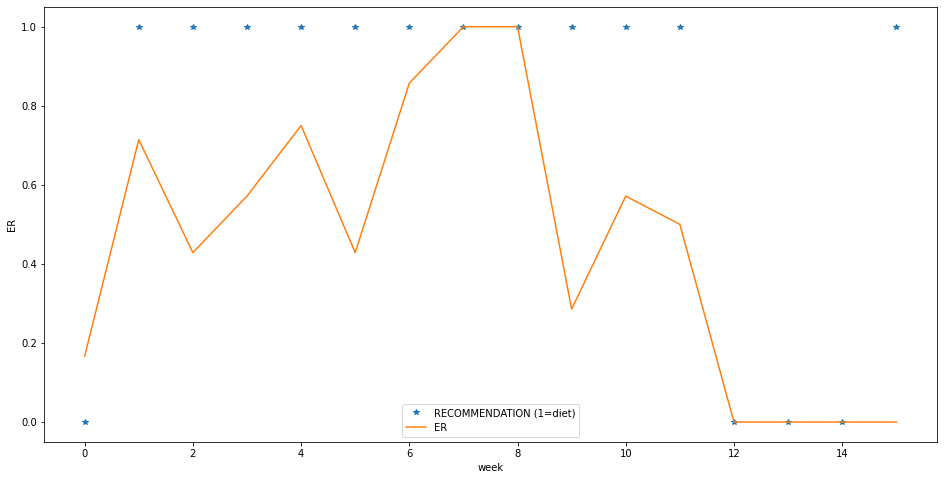

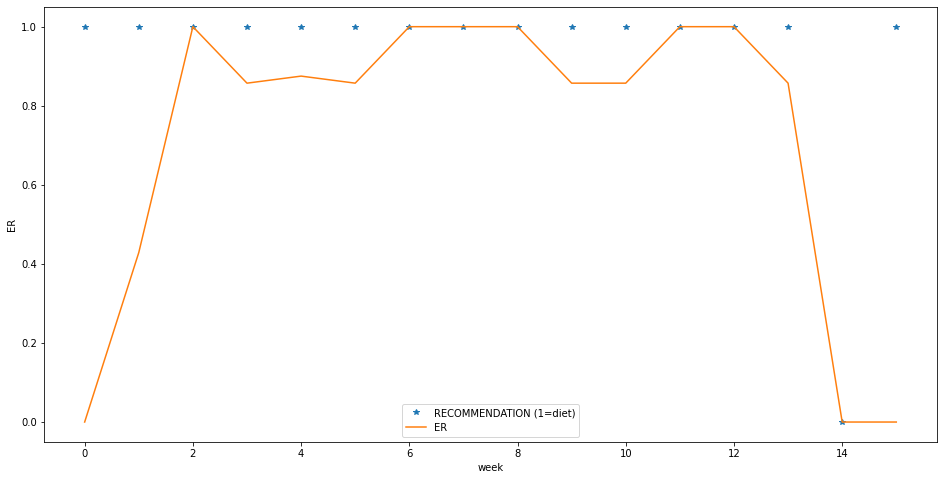

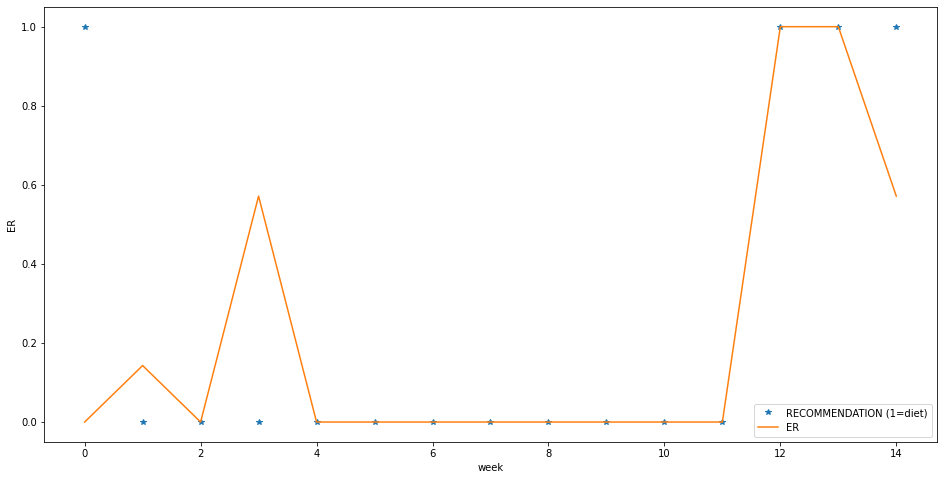

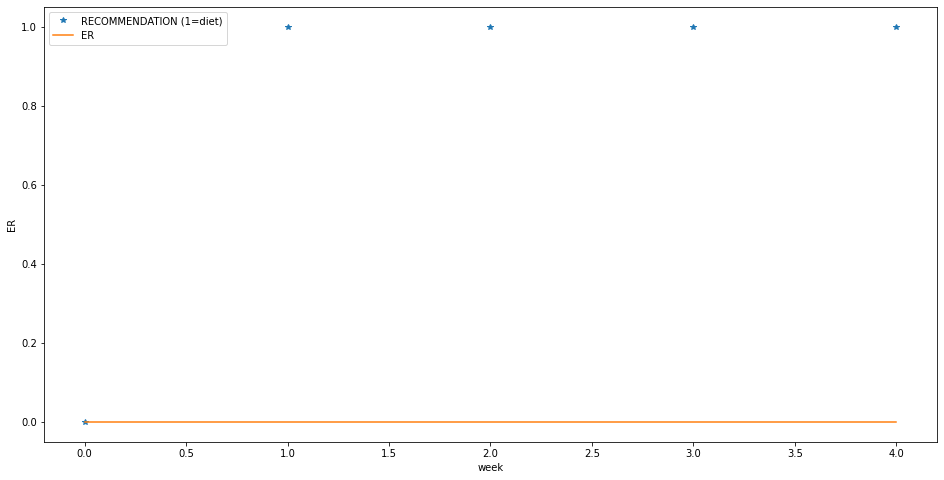

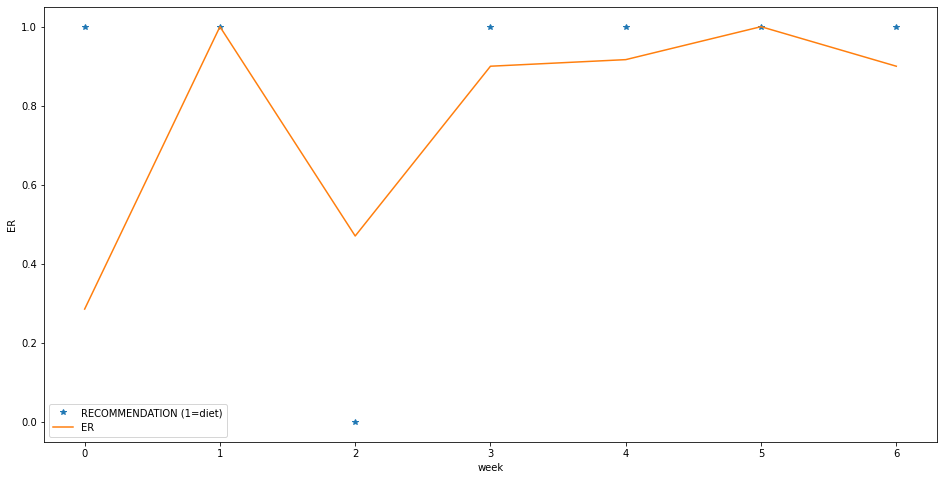

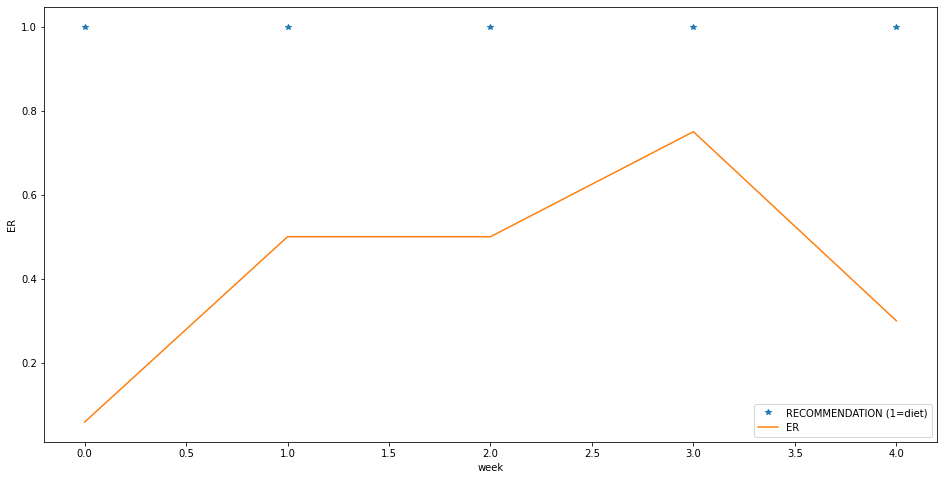

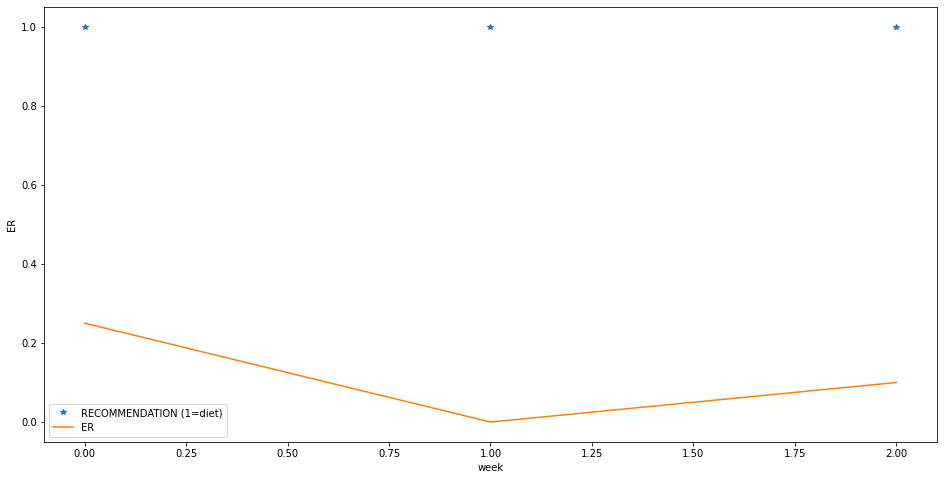

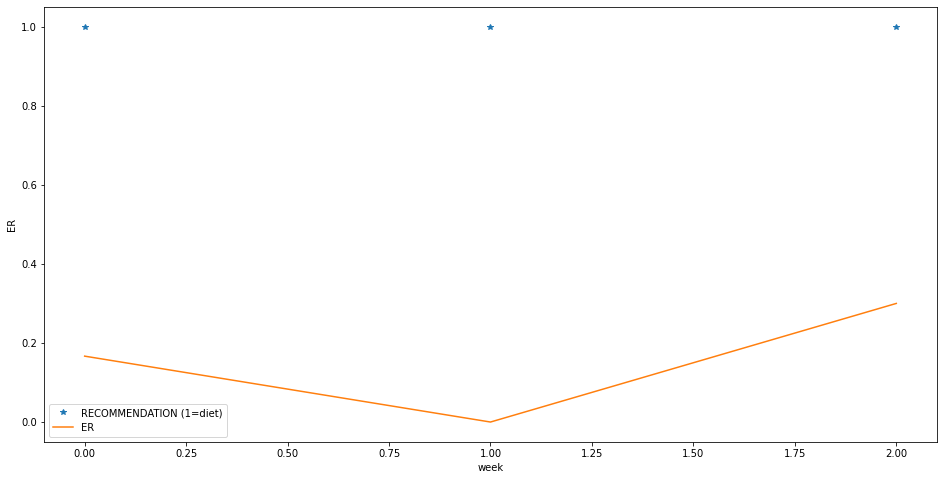

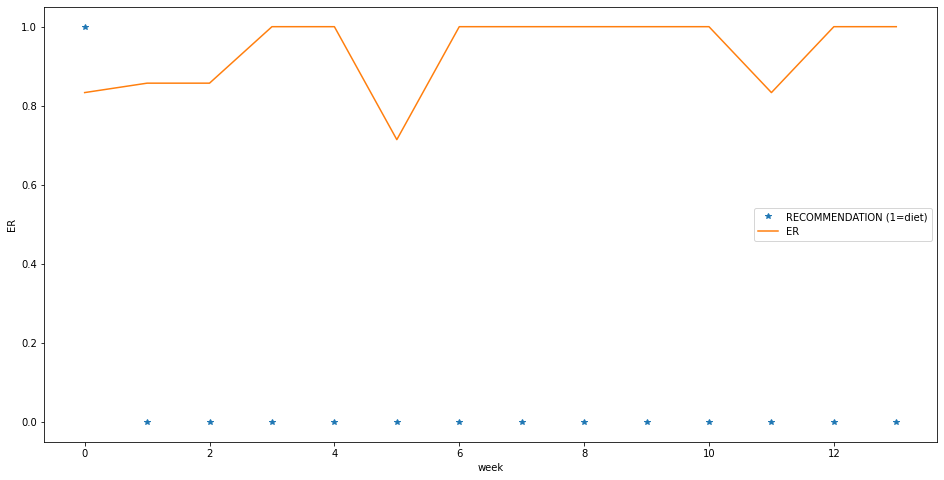

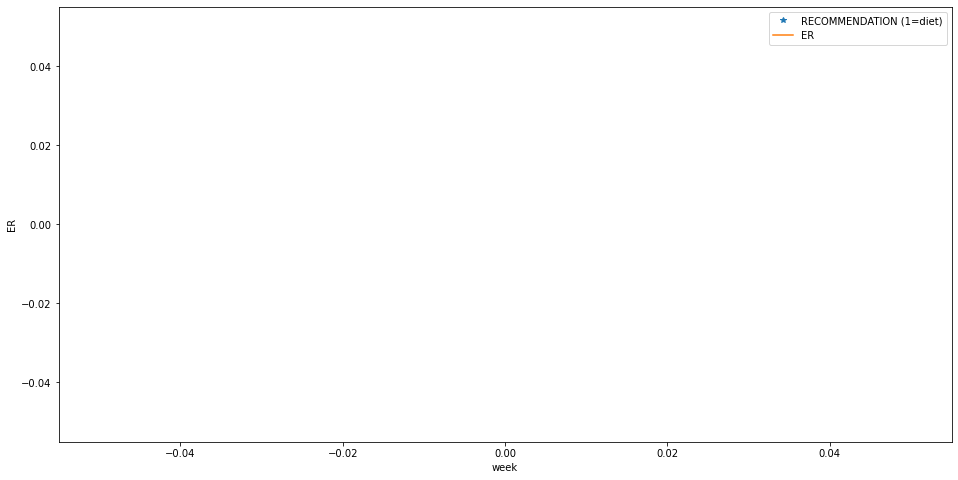

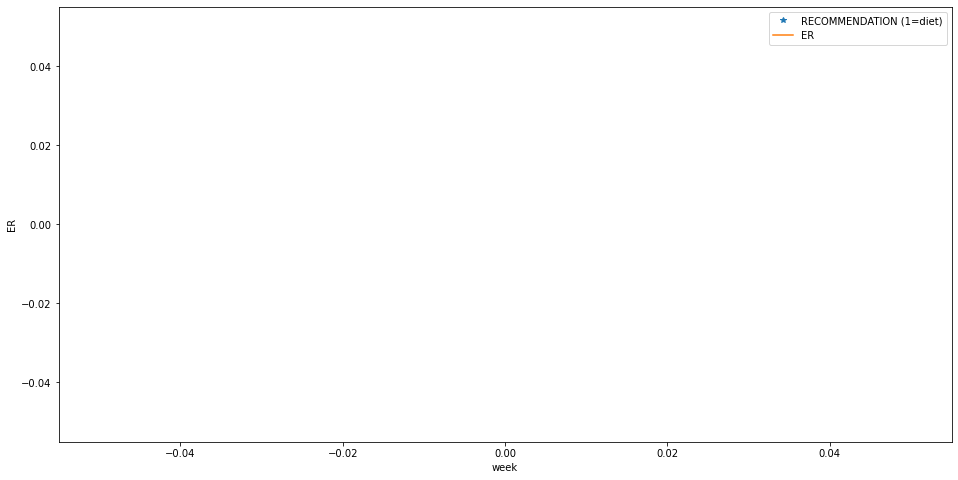

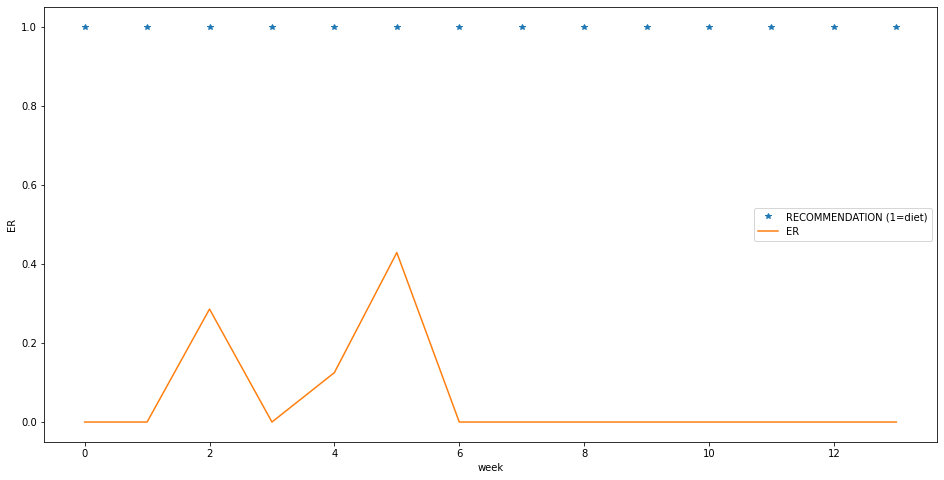

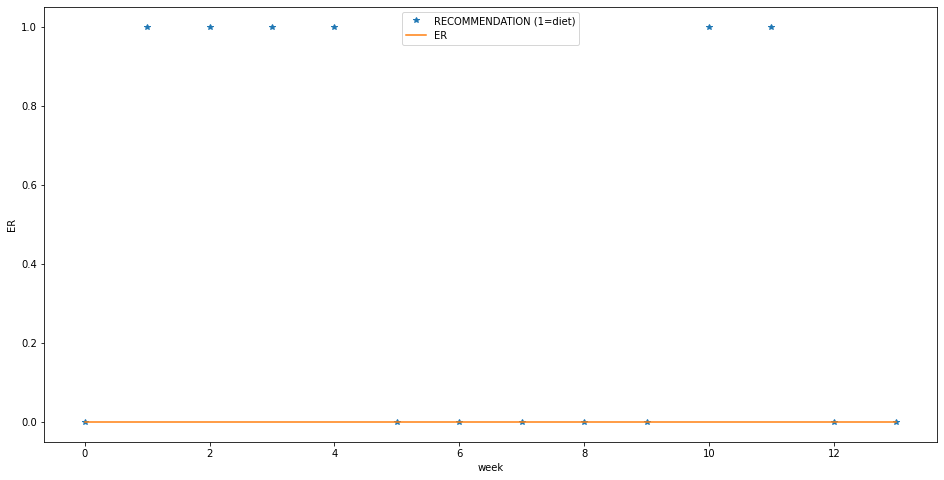

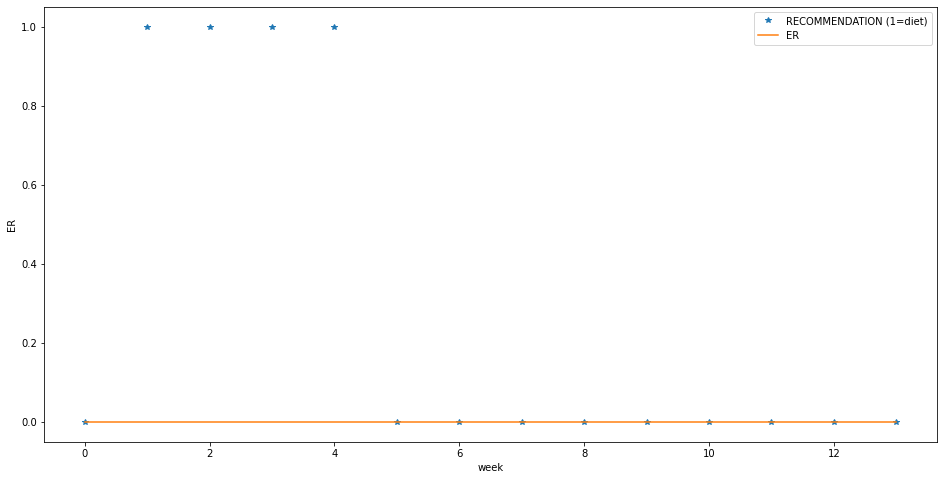

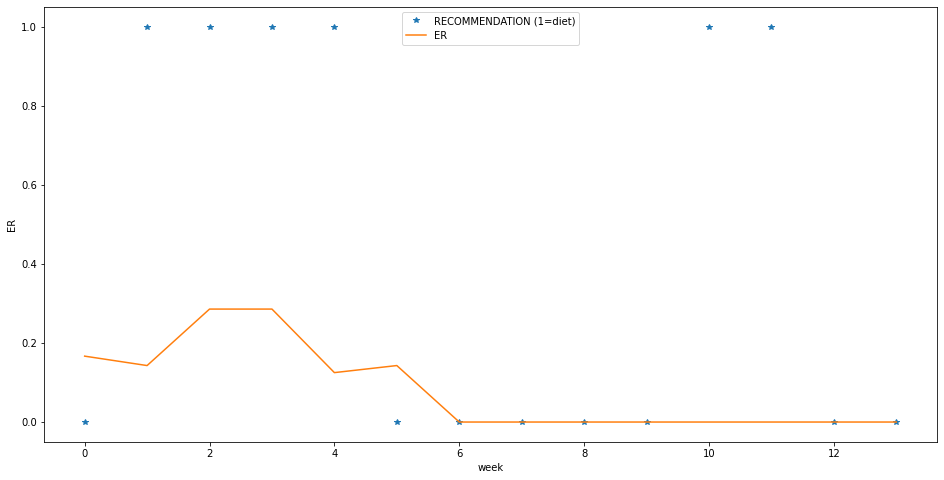

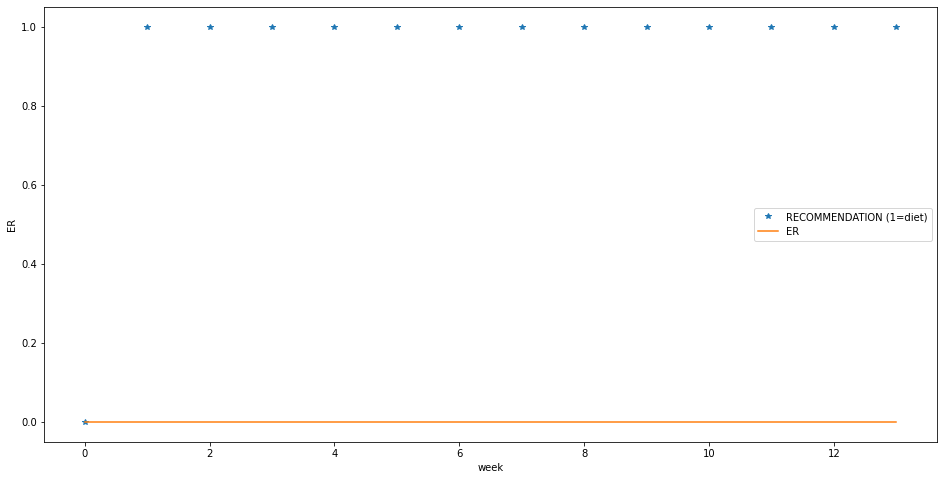

In [ ]:
for i in range(len(rrecs)):
  plt.figure(figsize=(16, 8))
  plt.plot(list(range(len(rrecs[i]))), rrecs[i], '*', list(range(len(rrecs[i]))), eers[i])
  plt.legend(['RECOMMENDATION (1=diet)', 'ER'])
  plt.xlabel('week')
  plt.ylabel('ER')
  plt.show()

In [ ]:
max_len = max([len(s) for s in eers])

In [ ]:
new_er = []
for er in eers:
  if sum(er) == 0:
    continue
  if len(er) < max_len:
    er = [0]*(max_len - len(er)) + er
  new_er.append(np.array(er))
new_er = np.vstack(new_er)

In [ ]:
train = new_er[:, :-1]
true_pred = new_er[:, -1]

In [ ]:
true_pred

array([0.        , 0.        , 0.57142857, 0.9       , 0.3       ,
       0.1       , 0.3       , 1.        , 0.        , 0.        ])

In [ ]:
startDate = '2020-09-01'
endDate = '2020-12-14'

In [ ]:
date_rng = pd.date_range(start=datetime.datetime.strptime(startDate, "%Y-%m-%d"), 
                         end=datetime.datetime.strptime(endDate, "%Y-%m-%d"), 
                         freq='W')

In [ ]:
date_rng

DatetimeIndex(['2020-09-06', '2020-09-13', '2020-09-20', '2020-09-27',
               '2020-10-04', '2020-10-11', '2020-10-18', '2020-10-25',
               '2020-11-01', '2020-11-08', '2020-11-15', '2020-11-22',
               '2020-11-29', '2020-12-06', '2020-12-13'],
              dtype='datetime64[ns]', freq='W-SUN')

In [ ]:
preds = []
for i in range(train.shape[0]):
  df = pd.DataFrame(date_rng, columns=['date'])
  df['data'] = train[i]
  df['datetime'] = pd.to_datetime(df['date'])
  df = df.set_index('datetime')
  df.drop(['date'], axis=1, inplace=True)

  model = ARIMA(df, order=(3, 1, 0))
  model_fit = model.fit(disp=1)
  preds.append(model_fit.predict(start="2020-12-20")[0])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/usr/local/lib/

In [ ]:
anova(preds, true_pred)

0.026195981834259644

In [ ]:
ttest(preds, true_pred)

0.026195981834259734

# Weekly predictions

In [ ]:
df = pd.read_csv('data/GC-Predictive-Analytics-worksheet - Sheet1 - week6.csv')
df = df.drop([11, 12])
df = df.reset_index()
del df['cluster']
del df['Unnamed: 12']

df['Age'] = df['Age'].replace("40-50's", '45')
df['Age'] = df['Age'].astype('int32')

In [ ]:
rec_idxs = [str(i) for i in range(1, 15)]
er_idxs = ['ER']
er_idxs.extend(['ER.{}'.format(i) for i in range(1, 14)])
rec_idxs.append('16 Recommendation ')
rec_idxs.append('17 Recommendation')
er_idxs.append('Actual ER')
er_idxs.append('Actual ER.1')

In [ ]:
rrecs = []
eers = []
iids = []
for i in range(len(df)):
  recs = []
  ers = []
  for rec, er in zip(rec_idxs, er_idxs):
      recomendation = df[rec][i]
      try:
        engagement = float(df[er][i])
      except ValueError:
        engagement = 0.0
      if pd.isna(recomendation):
        continue
      elif recomendation == 'Phy':
        recomendation = 0
      else:
        recomendation = 1
      recs.append(recomendation)
      ers.append(engagement)
  rrecs.append(recs)
  eers.append(ers)

In [ ]:
sum_diet = 0
sum_phy = 0
diet_n = 0
phy_n = 0
for ers_, rec_ in zip(eers, rrecs):
  for i in range(len(ers_)):
    if rec_[i] == 1:
      sum_diet += ers_[i]
      diet_n += 1
    else:
      sum_phy += ers_[i]
      phy_n += 1

diet = sum_diet / diet_n
phy = sum_phy / phy_n

In [ ]:
diet

0.33028784430218744

In [ ]:
phy

0.2400511928913793

In [ ]:
max_len = max([len(s) for s in eers])

In [ ]:
new_er = []
for er in eers:
  # if sum(er) == 0:
  #   continue
  if len(er) < max_len:
    er = [0]*(max_len - len(er)) + er
  new_er.append(np.array(er))
new_er = np.vstack(new_er)

In [ ]:
rows = [2, 4, 5, 6, 7]
new_er = new_er[rows, :]

In [ ]:
startDate = '2020-09-01'
endDate = '2020-12-20'
date_rng = pd.date_range(start=datetime.datetime.strptime(startDate, "%Y-%m-%d"), 
                         end=datetime.datetime.strptime(endDate, "%Y-%m-%d"), 
                         freq='W')

In [ ]:
preds = []
for i in range(new_er.shape[0]):
  df = pd.DataFrame(date_rng, columns=['date'])
  df['data'] = new_er[i]
  df['datetime'] = pd.to_datetime(df['date'])
  df = df.set_index('datetime')
  df.drop(['date'], axis=1, inplace=True)

  model = ARIMA(df, order=(3, 1, 0))
  model_fit = model.fit(disp=1)
  preds.append(model_fit.predict(start="2020-12-27")[0])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)
/usr/local/lib/

In [ ]:
for r, p in zip(rows, preds):
  print('{}:{}'.format(r, p))

2:0.060415466714210456
4:0.15009046298640752
5:0.1018601117732206
6:0.024422947733754453
7:-0.2693955909225728


# Regression model with selected features

In [ ]:
df = pd.read_csv('data/GC-Predictive-Analytics-worksheet - Sheet1 - week6.csv')
df = df.drop([11, 12])
df = df.reset_index()
del df['cluster']
del df['Unnamed: 12']

df['Age'] = df['Age'].replace("40-50's", '45')
df['Age'] = df['Age'].astype('int32')

In [ ]:
rec_idxs = [str(i) for i in range(1, 15)]
er_idxs = ['ER']
er_idxs.extend(['ER.{}'.format(i) for i in range(1, 14)])
rec_idxs.append('16 Recommendation ')
rec_idxs.append('17 Recommendation')
er_idxs.append('Actual ER')
er_idxs.append('Actual ER.1')

In [ ]:
rrecs = []
eers = []
iids = []
lines = []
for i in range(len(df)):
  recs = []
  ers = []
  for rec, er in zip(rec_idxs, er_idxs):
      recomendation = df[rec][i]
      try:
        engagement = float(df[er][i])
      except ValueError:
        engagement = 0.0
      if pd.isna(recomendation):
        continue
      elif recomendation == 'Phy':
        recomendation = 0
      else:
        recomendation = 1
      recs.append(recomendation)
      ers.append(engagement)
  rrecs.append(recs)
  eers.append(ers)
  gender = df.Gender[i]
  hours = df['Work hours'][i]
  hmap = {'1-15 hrs/week': 0.2, '16-35 hrs/week': 0.4, '36-50 hrs/week': 0.6, '50+ hrs/week': 1.0}
  if hours in hmap:
    hours = hmap[hours]
  else:
    hours = 0.0
  if gender == 'Female':
    gender = 0
  else:
    gender = 1
  motivation = df.Motivation[i]	
  if pd.isna(motivation):
    motivation = 0.0
  attitude = df.Attitude[i]
  if pd.isna(attitude):
    attitude = 0
  intention = df.Intention[i]
  if pd.isna(intention):
    intention = 0
  ownership = df.Ownership[i]
  if pd.isna(ownership):
    ownership = 0
  iids.append(dict(age = df.Age[i] / 82,
                   gender = gender,  
                   motivation = motivation,	
                   attitude = attitude, 
                   intention = intention,
                   ownership = ownership,
                   hours = hours))

In [ ]:
X = []
y = []
for i in range(len(rrecs)):
  for j in range(len(rrecs[i]) - 2):
    r1 = rrecs[i][j]
    r2 = rrecs[i][j+1]
    # X.append([eers[i][j], r2 - r1, r1, r2, iids[i]['age']])
    X.append([eers[i][j], r1, r2, r2-r1, iids[i]['age'], iids[i]['motivation']]) #iids[i]['attitude']])
    y.append(eers[i][j+1])

In [ ]:
test_x = []
test_y = []

for i in range(len(rrecs)):
  if len(rrecs[i]) < 2:
    continue
  r1 = rrecs[i][-2]
  r2 = rrecs[i][-1]
  test_x.append([eers[i][-2], r1, r2, r2-r1, iids[i]['age'], iids[i]['motivation']])
  test_y.append(eers[i][-1])

In [ ]:
test_x

[[0.0, 0, 1, 1, 0.5365853658536586, 0.2656231692],
 [0.0, 0, 1, 1, 0.45121951219512196, 0.38612782090000003],
 [1.0, 1, 1, 0, 0.7682926829268293, 0.1475109276],
 [0.0, 1, 1, 0, 0.45121951219512196, 0.4920412394],
 [1.0, 1, 1, 0, 0.7560975609756098, 0.5941193599],
 [0.75, 1, 1, 0, 0.7195121951219512, 0.7606024253],
 [0.0, 1, 1, 0, 0.34146341463414637, 0.653542647],
 [0.0, 1, 1, 0, 0.7317073170731707, 0.7367078616],
 [1.0, 0, 0, 0, 0.6951219512195121, 0.5505932954],
 [0.0, 1, 1, 0, 0.4878048780487805, 0.6891558439],
 [0.0, 0, 0, 0, 0.4146341463414634, 0.653391631],
 [0.0, 0, 0, 0, 0.7682926829268293, 0.0],
 [0.0, 0, 0, 0, 0.5975609756097561, 0.0],
 [0.0, 1, 1, 0, 0.9878048780487805, 0.10177911070000001]]

In [ ]:
models = []
models.append(('Linear', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('Elastic', ElasticNet()))
models.append(('RegTree', RandomForestRegressor()))

# evaluate each model in turn
for name, model in models:
    cv_results = cross_val_score(model, X, y, cv=KFold(n_splits=5, shuffle=True), scoring='r2')
    print("{}: {:.3f} ({})".format(name, cv_results.mean(), cv_results))

Linear: 0.646 ([0.56825597 0.63374897 0.71449464 0.50915871 0.80509446])
Ridge: 0.673 ([0.46589742 0.62466389 0.83887025 0.83535422 0.60230352])
Lasso: -0.004 ([-0.00076975 -0.00033373 -0.00924655 -0.00789453 -0.00307641])
Elastic: -0.002 ([-2.87344815e-03 -2.23319293e-03 -8.69882737e-06 -3.34551895e-03
 -2.61514597e-03])
RegTree: 0.615 ([0.35567818 0.75364061 0.59935824 0.71737626 0.64995319])


In [ ]:
poly = PolynomialFeatures(2)
X_ = poly.fit_transform(X)

In [ ]:
models = []
models.append(('Linear', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('Elastic', ElasticNet()))
models.append(('RegTree', RandomForestRegressor()))

# evaluate each model in turn
for name, model in models:
    cv_results = cross_val_score(model, X_, y, cv=KFold(n_splits=5, shuffle=True), scoring='r2')
    print("{}: {:.3f} ({})".format(name, cv_results.mean(), cv_results))

Linear: 0.713 ([0.80852101 0.80927755 0.48889947 0.74633341 0.71036431])
Ridge: 0.684 ([0.72612409 0.79729255 0.60152815 0.6276577  0.6679265 ])
Lasso: -0.013 ([-0.0034841  -0.00459995 -0.04908544 -0.00159452 -0.0046575 ])
Elastic: -0.051 ([-0.05505189 -0.0326652  -0.01544483 -0.11617535 -0.03354154])
RegTree: 0.624 ([0.63040752 0.6500289  0.75691345 0.47241714 0.61100008])


In [ ]:
poly = PolynomialFeatures(2)
X_ = poly.fit_transform(X)
model = RandomForestRegressor()
model.fit(X_, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
pred = model.predict(poly.transform(test_x))
print('{} Anova: {} ttest: {}'.format(name, anova(pred, test_y), ttest(pred, test_y)))

RegTree Anova: 0.6693126126806433 ttest: 0.6693126126806452


In [ ]:
model = LinearRegression()
model.fit(X_, y)
pred = model.predict(poly.transform(test_x))
print('{} Anova: {} ttest: {}'.format(name, anova(pred, test_y), ttest(pred, test_y)))

RegTree Anova: 0.5691908258816754 ttest: 0.5691908258816754


In [ ]:
for i in [0, 1, 2, 3, 4, 5, 6, 7, 8]:
    r1 = rrecs[i][-1]
    diet_er = model.predict(poly.transform(np.array([eers[i][-1], r1, 1 - r1, 1, iids[i]['age'], iids[i]['motivation']]).reshape(1, -1)))
    phy_er = model.predict(poly.transform(np.array([eers[i][-1], r1, 0 - r1, 0, iids[i]['age'], iids[i]['motivation']]).reshape(1, -1)))
    if diet_er > phy_er:
      print('id: {} recomendation: {} er: {}'.format(i, 'diet', diet_er[0]))
    else:
      print('id: {} recomendation: {} er: {}'.format(i, 'Phy', phy_er[0]))

id: 0 recomendation: diet er: 0.2925344060780313
id: 1 recomendation: diet er: 0.23000000001100013
id: 2 recomendation: diet er: 0.355670168065
id: 3 recomendation: diet er: 0.041428571429
id: 4 recomendation: Phy er: 0.8837263655499693
id: 5 recomendation: diet er: 0.5582153361354
id: 6 recomendation: diet er: 0.14214285714800004
id: 7 recomendation: diet er: 0.5592153361354
id: 8 recomendation: Phy er: 0.9354861111082058


In [ ]:
y

[0.7142857143000001,
 0.42857142859999997,
 0.5714285714,
 0.75,
 0.42857142859999997,
 0.8571428570999999,
 1.0,
 1.0,
 0.2857142857,
 0.5714285714,
 0.5,
 0.0,
 0.0,
 0.0,
 0.42857142859999997,
 1.0,
 0.8571428570999999,
 0.875,
 0.8571428570999999,
 1.0,
 1.0,
 1.0,
 0.8571428570999999,
 0.8571428570999999,
 1.0,
 1.0,
 0.8571428570999999,
 0.0,
 0.14285714289999998,
 0.0,
 0.5714285714,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.4705882353,
 0.9,
 0.9166666667,
 1.0,
 0.5,
 0.5,
 0.75,
 0.0,
 0.0,
 0.8571428570999999,
 0.8571428570999999,
 1.0,
 1.0,
 0.7142857143000001,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8333333333,
 1.0,
 0.0,
 0.2857142857,
 0.0,
 0.125,
 0.42857142859999997,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.14285714289999998,
 0.2857142857,
 0.2857142857,
 0.125,
 0.14285714289999998

In [ ]:
len(iids)

16